<a href="https://colab.research.google.com/github/fernandofsilva/thesis/blob/main/Notebook_Options_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('darkgrid')

# Load data

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Datasets/data_option.csv')
data['date'] = pd.to_datetime(data['date'])
data.index = data['date']
data = data.drop(['date'], axis=1)
data.head()

,option,value,X,expire,option_type,T,S,volume,r,sigma
date,,,,,,,,,,
2015-01-05,PETRC53,0.65,9.61,2015-03-16,call,0.190476,8.61,674783884.0,11.57,77.182444
2015-01-05,PETRC50,0.90,9.01,2015-03-16,call,0.190476,8.61,674783884.0,11.57,77.182444
2015-01-05,PETRC51,0.81,9.21,2015-03-16,call,0.190476,8.61,674783884.0,11.57,77.182444
2015-01-05,PETRC52,0.73,9.41,2015-03-16,call,0.190476,8.61,674783884.0,11.57,77.182444
2015-01-05,PETRC54,0.61,9.81,2015-03-16,call,0.190476,8.61,674783884.0,11.57,77.182444


# DNN

## Pipeline

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('value')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

## Train and Test

In [ ]:
train = data[:'2018-01-01']
test = data['2018-01-01':]

batch_size = 22 
train_ds = df_to_dataset(train, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## Feature Columns

In [ ]:
feature_columns = []

# Numeric columns
for header in ['S', 'X', 'T', 'r', 'sigma']:
  feature_columns.append(tf.feature_column.numeric_column(header))

# Categorial columns
option = tf.feature_column.categorical_column_with_vocabulary_list('option_type', ['call', 'put'])
option_one_hot = tf.feature_column.indicator_column(option)
feature_columns.append(option_one_hot)

### Create a feature layer

In [ ]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Keras Tuner

In [ ]:
!pip install -U keras-tuner
import kerastuner as kt

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


## Tuner Model

In [ ]:
def model_builder(hp):

    # Create model
    model = tf.keras.Sequential()
    
    # Input layer
    # model.add(tf.keras.layers.Flatten(feature_layer))
    
    # Tune the number of units
    hp_units = hp.Int('units', min_value = 64, max_value = 512, step = 64)
    model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1))

    # Tune the learning rate for the optimizer 
    hp_lr = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = hp_lr),
        loss = tf.keras.losses.MeanSquaredError(), 
        metrics = [tf.keras.metrics.RootMeanSquaredError()]
    )
    
    return model

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective = 'val_loss',
    max_epochs = 10,
    factor = 3,
    directory = 'my_dir',
    project_name = 'dnn_opcoes'
) 

Define callback to clear the weights each step

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [ ]:
tuner.search(train_ds, epochs = 10, validation_data = test_ds, callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Model

## Create, compile, and train the model

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.fit(train_ds, epochs = 10, validation_data = test_ds)

In [ ]:
model = tf.keras.Sequential([
  feature_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None)]
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50
)

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

5422/5422 [==============================] - 14s 3ms/step - loss: 0.6129 - root_mean_squared_error: 0.7829 - val_loss: 0.8671 - val_root_mean_squared_error: 0.9312
Epoch 2/50
5422/5422 [==============================] - 14s 3ms/step - loss: 0.0707 - root_mean_squared_error: 0.2660 - val_loss: 0.4607 - val_root_mean_squared_error: 0.6788
Epoch 3/50
5422/5422 [==============================] - 14s 3ms/step - loss: 0.0536 - root_mean_squared_error: 0.2315 - val_loss: 0.4382 - val_root_mean_squar

In [ ]:
# Plot ATM
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(history['bs'], label='bs')
ax.plot(CATM['dnn'], label='dnn')
ax.set_ylabel('Valor de Perda')
ax.legend()

plt.show()

# Black-Scholes

In [ ]:
from scipy.stats import norm

# Auxiliary function for d_one risk-adjusted probability
def d11(S, X, T, r, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))

# Auxiliary function for d_two risk-adjusted probability
def d21(d1, T, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return d1 - sigma * np.sqrt(T)

# Definition of the Black-Scholes delta function
def bs_delta(S, X, T, r, sigma, option_type):
    """Compute the delta of the Black-Scholes option pricing formula.

    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'

    Returns: a numpy.float_ representing the delta value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    if option_type == 'call':
        return norm.cdf(d11(S, X, T, r, sigma))
    elif option_type == 'put':
        return norm.cdf(-d11(S, X, T, r, sigma))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

# Definition of the Black-Scholes European option pricing formula
def black_scholes(S, X, T, r, sigma, option_type):
    """Price a European option using the Black-Scholes option pricing formula.

    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'

    Returns: a numpy.float_ representing the option value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    d_one = d11(S, X, T, r, sigma)
    d_two = d21(d_one, T, sigma)
    if option_type == 'call':
        return S * norm.cdf(d_one) - np.exp(-r * T) * X * norm.cdf(d_two)
    elif option_type == 'put':
        return -(S * norm.cdf(-d_one) - np.exp(-r * T) * X * norm.cdf(-d_two))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

def bs_pandas(row):
    value = black_scholes(
        row['S'], row['X'], row['T'], row['r']/100, row['sigma']/100, row['option_type']
    )
    return round(value, 2)

def delta_pandas(row):
    value = bs_delta(
        row['S'], row['X'], row['T'], row['r']/100, row['sigma']/100, row['option_type']
    )
    return int(round(value * 100, 0))



# Comparison

In [ ]:
call_atm = 'PETRJ270'
put_atm = 'PETRV270'

call_otm = 'PETRJ327'
put_otm = 'PETRV231'

call_itm = 'PETRJ241'
put_itm =  'PETRV290'

# ATM
CATM = data[(data['option'] == call_atm) & (data['expire'] == '2019-10-21')]
CATM = CATM['2019-09-01':]

PATM = data[(data['option'] == put_atm) & (data['expire'] == '2019-10-21')]
PATM = PATM['2019-09-01':]

# OTM
COTM = data[(data['option'] == call_otm) & (data['expire'] == '2019-10-21')]
COTM = COTM['2019-09-01':]

POTM = data[(data['option'] == put_otm) & (data['expire'] == '2019-10-21')]
POTM = POTM['2019-09-01':]

# ITM
CITM = data[(data['option'] == call_itm) & (data['expire'] == '2019-10-21')]
CITM = CITM['2019-09-01':]

PITM = data[(data['option'] == put_itm) & (data['expire'] == '2019-10-21')]
PITM = PITM['2019-09-01':]

In [ ]:
# ATM
CATM_ds = df_to_dataset(CATM, shuffle=False, batch_size=batch_size)
PATM_ds = df_to_dataset(PATM, shuffle=False, batch_size=batch_size)

# OTM
COTM_ds = df_to_dataset(COTM, shuffle=False, batch_size=batch_size)
POTM_ds = df_to_dataset(POTM, shuffle=False, batch_size=batch_size)

# ITM
CITM_ds = df_to_dataset(CITM, shuffle=False, batch_size=batch_size)
PITM_ds = df_to_dataset(PITM, shuffle=False, batch_size=batch_size)

# Prediction
pred_CATM = model.predict(CATM_ds)
pred_PATM = model.predict(PATM_ds)

pred_COTM = model.predict(COTM_ds)
pred_POTM = model.predict(POTM_ds)

pred_CITM = model.predict(CITM_ds)
pred_PITM = model.predict(PITM_ds)

# Add to the dataframe
CATM['dnn'] = pred_CATM
PATM['dnn'] = pred_PATM

COTM['dnn'] = pred_COTM
POTM['dnn'] = pred_POTM

CITM['dnn'] = pred_CITM
PITM['dnn'] = pred_PITM

In [ ]:
# Apply black-scholes formula
CATM['bs'] = CATM.apply(bs_pandas, axis=1)
PATM['bs'] = PATM.apply(bs_pandas, axis=1)

COTM['bs'] = COTM.apply(bs_pandas, axis=1)
POTM['bs'] = POTM.apply(bs_pandas, axis=1)

CITM['bs'] = CITM.apply(bs_pandas, axis=1)
PITM['bs'] = PITM.apply(bs_pandas, axis=1)

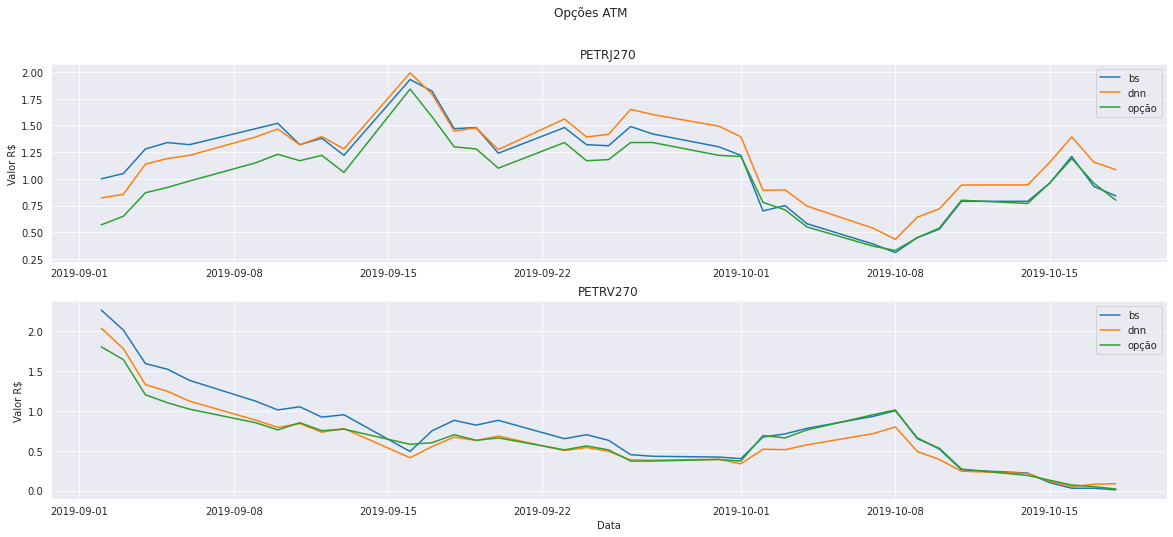

2/2 [==============================] - 0s 1ms/step - loss: 0.0113 - root_mean_squared_error: 0.1065
DNN Call: 0.2108, Put: 0.1065
Black-Scholes Call: 0.1947, Put: 0.1901


In [ ]:
# Plot ATM
fig, axs = plt.subplots(2, figsize=(20, 8))
fig.suptitle('Opções ATM')

axs[0].title.set_text(call_atm)
axs[0].plot(CATM['bs'], label='bs')
axs[0].plot(CATM['dnn'], label='dnn')
axs[0].plot(CATM['value'], label='opção')
axs[0].set_ylabel('Valor R$')
axs[0].legend()

axs[1].title.set_text(put_atm)
axs[1].plot(PATM['bs'], label='bs')
axs[1].plot(PATM['dnn'], label='dnn')
axs[1].plot(PATM['value'], label='opção')
axs[1].set_ylabel('Valor R$')
axs[1].set_xlabel('Data')
axs[1].legend()

plt.show()

loss, call = model.evaluate(CATM_ds)
loss, put = model.evaluate(PATM_ds)
print(f"DNN Call: {call:.4f}, Put: {put:.4f}", )

mse_call = np.sqrt(mean_squared_error(CATM['value'], CATM['bs']))
mse_put = np.sqrt(mean_squared_error(PATM['value'], PATM['bs']))
print(f"Black-Scholes Call: {mse_call:.4f}, Put: {mse_put:.4f}")

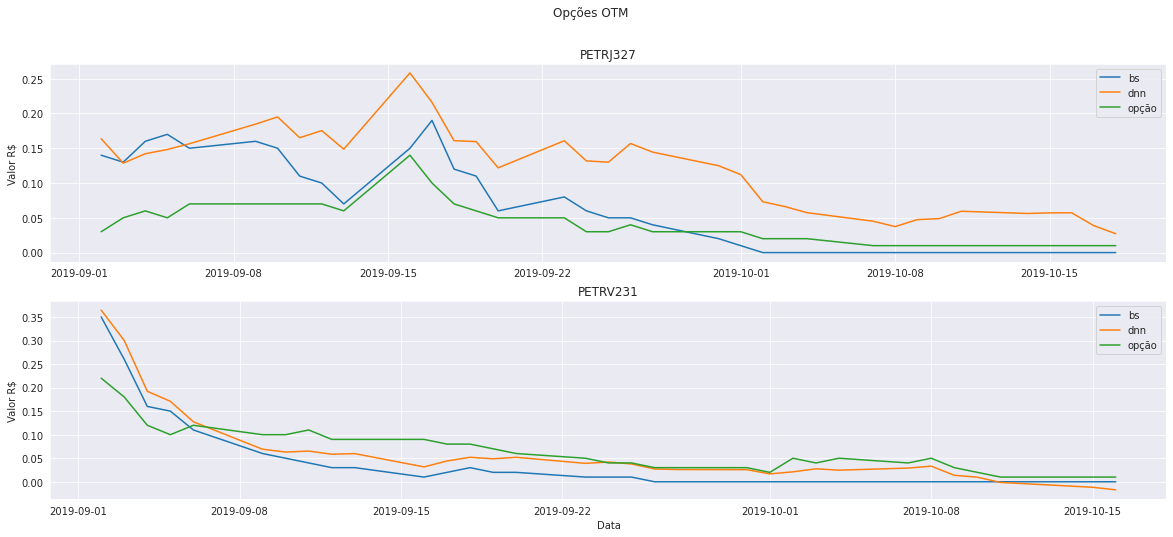

1/1 [==============================] - 0s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439
DNN Call: 0.0849, Put: 0.0439
Black-Scholes Call: 0.0492, Put: 0.0497


In [ ]:
# Plot OTM
fig, axs = plt.subplots(2, figsize=(20, 8))
fig.suptitle('Opções OTM')

axs[0].title.set_text(call_otm)
axs[0].plot(COTM['bs'], label='bs')
axs[0].plot(COTM['dnn'], label='dnn')
axs[0].plot(COTM['value'], label='opção')
axs[0].set_ylabel('Valor R$')
axs[0].legend()

axs[1].title.set_text(put_otm)
axs[1].plot(POTM['bs'], label='bs')
axs[1].plot(POTM['dnn'], label='dnn')
axs[1].plot(POTM['value'], label='opção')
axs[1].set_ylabel('Valor R$')
axs[1].set_xlabel('Data')
axs[1].legend()

plt.show()

loss, call = model.evaluate(COTM_ds)
loss, put = model.evaluate(POTM_ds)
print(f"DNN Call: {call:.4f}, Put: {put:.4f}", )

mse_call = np.sqrt(mean_squared_error(COTM['value'], COTM['bs']))
mse_put = np.sqrt(mean_squared_error(POTM['value'], POTM['bs']))
print(f"Black-Scholes Call: {mse_call:.4f}, Put: {mse_put:.4f}", )

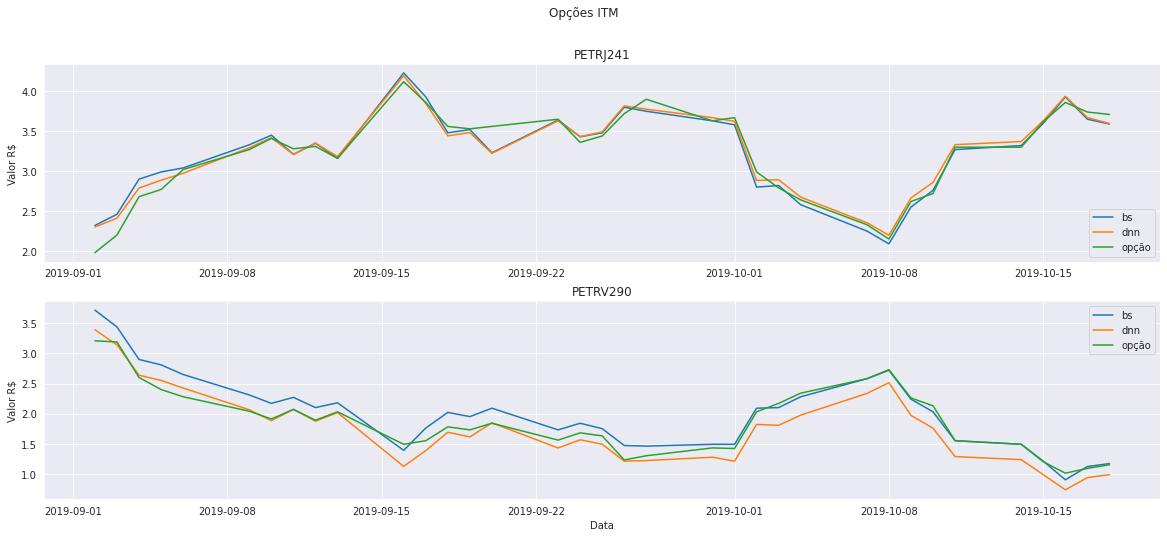

2/2 [==============================] - 0s 2ms/step - loss: 0.0382 - root_mean_squared_error: 0.1956
DNN Call: 0.1111, Put: 0.1956
Black-Scholes Call: 0.1258, Put: 0.1989


In [ ]:
# Plot ITM
fig, axs = plt.subplots(2, figsize=(20, 8))
fig.suptitle('Opções ITM')

axs[0].title.set_text(call_itm)
axs[0].plot(CITM['bs'], label='bs')
axs[0].plot(CITM['dnn'], label='dnn')
axs[0].plot(CITM['value'], label='opção')
axs[0].set_ylabel('Valor R$')
axs[0].legend(loc="lower right")

axs[1].title.set_text(put_itm)
axs[1].plot(PITM['bs'], label='bs')
axs[1].plot(PITM['dnn'], label='dnn')
axs[1].plot(PITM['value'], label='opção')
axs[1].set_ylabel('Valor R$')
axs[1].set_xlabel('Data')
axs[1].legend()

plt.show()

loss, call = model.evaluate(CITM_ds)
loss, put = model.evaluate(PITM_ds)
print(f"DNN Call: {call:.4f}, Put: {put:.4f}")

mse_call = np.sqrt(mean_squared_error(CITM['value'], CITM['bs']))
mse_put = np.sqrt(mean_squared_error(PITM['value'], PITM['bs']))
print(f"Black-Scholes Call: {mse_call:.4f}, Put: {mse_put:.4f}")